# Cluster Characterization

This notebook trains an Artificial Neural Network for cluster characterization.

## Initial settings

In [1]:
from cdalvaro.catalogues import OpenClust
from cdalvaro.data_base import DB
from cdalvaro.graphics import plot as cplt
from cdalvaro.logging import Logger
from cdalvaro.ml import DEC
from cdalvaro.ml.utils import cluster_centers, cluster_stats, estimate_n_clusters, filter_outliers
from cdalvaro.utils import safe_path
from IPython.display import Image
import logging
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from keras.initializers import glorot_uniform, VarianceScaling
from keras.optimizers import SGD
from keras.utils import plot_model

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_hd_-_firepro_d700.1"


In [2]:
logger = Logger.instance()
logger.setLevel(logging.ERROR)

# cplt.N_SAMPLES = 0
save_data = False

db = DB.instance(host='gaia.cdalvaro.io', port=15432)

clusters = OpenClust.catalogue()
cluster = clusters["Melotte 22"]

project_dir = Path("../..")
figures_path = project_dir / "figures" / safe_path(cluster.name)
save_dir = project_dir / "results" / safe_path(cluster.name)

figures_attr = {
    'save_dir': figures_path,
    'format': 'png',
    'dpi': 300
}

pm_attr = { 'xlim': (-30, 50), 'ylim': (-70, 40) }
parallax_attr = { 'xlim': (-4, 10), 'stat': 'density' }
hr_attr = { 'xlim': (-1, 4), 'ylim': (3, 21) }

for dir in [figures_path, save_dir]:
    dir.mkdir(exist_ok=True)

## Feature selection

In [3]:
variables = [
    "ra", "ra_error", "dec", "dec_error", "pmra", "pmra_error",
    "pmdec", "pmdec_error", "parallax", "parallax_error",
    "phot_g_mean_mag", "bp_rp"
]

non_null_columns = list(filter(lambda x: not re.search(r'_error', x), variables))

## Stars selection

In [4]:
stars_df = db.get_stars(region=cluster, columns=variables, filter_null_columns=non_null_columns)

stars_df = stars_df[(np.abs(stars_df['pmra']) > 0.0)
                    & (np.abs(stars_df['pmdec']) > 0.0)
                    & (np.abs(stars_df['parallax']) > 0.0)]

stars_df['pmra_corr'] = stars_df['pmra'] * 1000.0 / stars_df['parallax']
stars_df['pmdec_corr'] = stars_df['pmdec'] * 1000.0 / stars_df['parallax']

stars_df['pmmod'] = np.sqrt(stars_df['pmra_corr'] ** 2 + stars_df['pmdec_corr'] ** 2)
stars_df['pmang'] = np.arctan2(stars_df['pmdec_corr'], stars_df['pmra_corr'])

print(f"Number of stars: {stars_df.shape[0]}")
stars_df.head()

Number of stars: 52382


ra  ra_error        dec  dec_error  \
region_id source_id                                                      
302       64035217900973056  56.965683  0.731908  22.636288   0.455961   
          64035217900973440  56.957961  0.344281  22.631481   0.216900   
          64035217901215616  56.966256  0.904192  22.632545   0.525417   
          64035351043566208  56.917301  0.166422  22.626708   0.103046   
          64035385403304960  56.925461  0.546319  22.634953   0.311519   

                                 pmra  pmra_error     pmdec  pmdec_error  \
region_id source_id                                                        
302       64035217900973056  2.848682    1.711448 -3.291204     1.115977   
          64035217900973440  0.894901    0.804658 -3.445501     0.523968   
          64035217901215616  7.924372    2.124344 -0.241281     1.378156   
          64035351043566208 -4.433802    0.372218 -2.584965     0.231818   
          64035385403304960  0.055990    1.334990 -1.760018     0.757478   

                             parallax  parallax_error  phot_g_mean_mag  \
region_id source_id                                                      
302       64035217900973056 -0.854332        0.799045        20.090477   
          64035217900973440  0.336814        0.382097        19.032112   
          64035217901215616 -0.990431        1.025846        20.290981   
          64035351043566208 -0.080650        0.193725        17.814991   
          64035385403304960  0.138322        0.599870        19.578548   

                                bp_rp     pmra_corr    pmdec_corr  \
region_id source_id                                                 
302       64035217900973056  1.341768  -3334.397284   3852.371739   
          64035217900973440  1.704838   2656.958416 -10229.676916   
          64035217901215616  1.651123  -8000.928819    243.611562   
          64035351043566208  1.016489  54975.852052  32051.647600   
          64035385403304960  1.114752    404.784211 -12724.083913   

                                    pmmod     pmang  
region_id source_id                                  
302       64035217900973056   5094.994923  2.284246  
          64035217900973440  10569.092574 -1.316681  
          64035217901215616   8004.636692  3.111154  
          64035351043566208  63636.879423  0.527836  
          64035385403304960  12730.520872 -1.538995

## Feature selection

In [5]:
features = ['pmra_corr', 'pmdec_corr', 'pmmod', 'parallax']

## Feature rescaling

In [6]:
scaler = MinMaxScaler()
x = scaler.fit_transform(stars_df[features])

## K-Means

In [7]:
## Step 1 - Creating and training K-means model
from sklearn.cluster import KMeans
n_clusters, kmeans = estimate_n_clusters(x, min_clusters=10, max_clusters=10, verbose=True)
stars_df['cluster_g'] = np.array([f"g{g}" for g in kmeans.predict(x)], dtype=str)

Silhouette score for 10 clusters: 0.5192
Best silhouette score is 0.5192 for 10 clusters


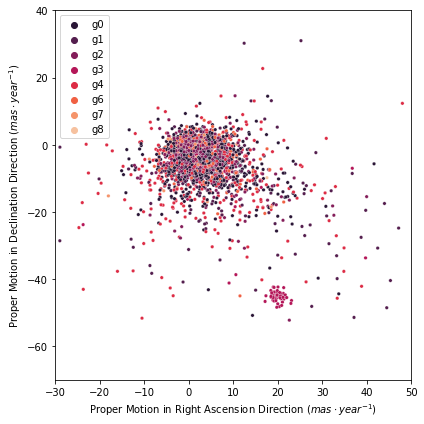

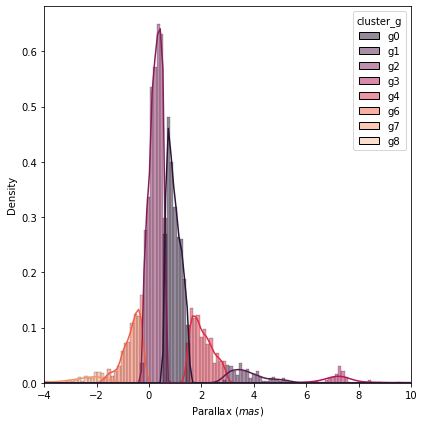

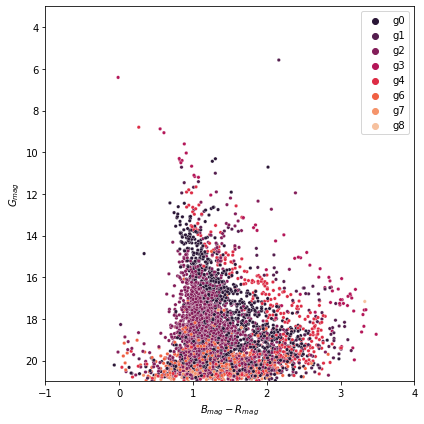

In [8]:
fig, ax, g = cplt.plot_cluster_proper_motion(stars_df, **pm_attr)
if save_data:
    cplt.save_figure(fig, name=f"kmeans_pm_{cluster.name}", **figures_attr)

fig, ax, g = cplt.plot_cluster_parallax_histogram(stars_df, **parallax_attr)
if save_data:
    cplt.save_figure(fig, name=f"kmeans_parallax_{cluster.name}", **figures_attr)

fig, ax, g = cplt.plot_cluster_hr_diagram_curve(stars_df, **hr_attr)
if save_data:
    cplt.save_figure(fig, name=f"kmeans_hr_diagram_{cluster.name}", **figures_attr)

In [9]:
cluster_centers(stars_df, key='cluster_g', columns=['pmra', 'pmdec', 'parallax'])

,pmra,pmdec,parallax
cluster_g,,,
g0,3.142339,-4.604834,0.976363
g1,8.578310,-12.700523,3.808002
g2,1.798338,-2.557344,0.252979
g3,19.591499,-40.696325,7.375615
g4,4.622545,-7.647597,2.041351
g5,-0.367071,-4.610185,0.000008
g6,1.503091,-2.374035,-0.693684
g7,0.776098,-2.695007,-2.759549
g8,89.747084,-99.770553,18.107298


In [10]:
kmeans_stats = cluster_stats(stars_df, key='cluster_g', columns=['pmra', 'pmdec', 'parallax'])
kmeans_stats.xs('std', axis=1, level=1, drop_level=False)

,pmra,pmdec,parallax
,std,std,std
cluster_g,,,
g0,6.235379,6.063514,0.249802
g1,20.496252,17.349784,0.700322
g2,3.754456,3.759994,0.218557
g3,21.029750,23.359612,0.927813
g4,10.473059,10.200907,0.391482
g5,NaN,NaN,NaN
g6,4.361958,3.944398,0.384772
g7,6.302488,5.211982,1.447925


In [11]:
stars_df['cluster_g'].value_counts()

g2    21194
g0    15112
g4     6431
g6     5595
g1     1955
g3     1083
g7      975
g8       35
g9        1
g5        1
Name: cluster_g, dtype: int64

In [12]:
if save_data:
    stars_df.to_csv(f"{save_dir}/kmeans_characterization_{safe_path(cluster.name)}.csv")

# Deep Embedded Clustering (DEC)

https://arxiv.org/pdf/1511.06335.pdf


In [13]:
# Reference:
#     Unsupervised Deep Embedding for Clustering Analysis - 4.3 Implementation
# dims = [x.shape[-1], 500, 500, 2000, 10]
dims = [x.shape[-1], 50, 50, 200, n_clusters]

loss = 'kld'
optimizer = SGD(1, 0.9)
init = VarianceScaling(scale=1.0/3.0, mode='fan_in', distribution='uniform', seed=11)
#init = glorot_uniform(seed=1)

# DEC model
dec = DEC(dims=dims, n_clusters=n_clusters, initializer=init)
dec.compile(optimizer=optimizer, loss=loss)
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
encoder_0 (Dense)            (None, 50)                250       
_________________________________________________________________
encoder_1 (Dense)            (None, 50)                2550      
_________________________________________________________________
encoder_2 (Dense)            (None, 200)               10200     
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                2010      
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 15,110
Trainable params: 15,110
Non-trainable params: 0
_________________________________________________________________


In [14]:
# plot_model(dec.model, to_file=f'{save_dir}/dec_model.png', show_shapes=True)
# Image(filename=f'{save_dir}/dec_model.png')

In [15]:
# Training parameters
epochs = 30
batch_size = 128
maxiter = 2000
update_interval = 20
verbose = 1

dec.pretrain(x, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
dec.fit(x, batch_size=batch_size, maxiter=maxiter, update_interval=update_interval, verbose=verbose)

Pretraining autoencoder model...
Epoch 1/30
52382/52382 [==============================] - 3s 65us/step - loss: 0.0028
Epoch 2/30
52382/52382 [==============================] - 3s 61us/step - loss: 1.3969e-04
Epoch 3/30
52382/52382 [==============================] - 3s 61us/step - loss: 1.4015e-04
Epoch 4/30
52382/52382 [==============================] - 3s 60us/step - loss: 1.4078e-04
Epoch 5/30
52382/52382 [==============================] - 3s 61us/step - loss: 1.4037e-04
Epoch 6/30
52382/52382 [==============================] - 3s 60us/step - loss: 1.3981e-04
Epoch 7/30
52382/52382 [==============================] - 3s 61us/step - loss: 1.4037e-04
Epoch 8/30
52382/52382 [==============================] - 3s 60us/step - loss: 1.4034e-04
Epoch 9/30
52382/52382 [==============================] - 3s 61us/step - loss: 1.3944e-04
Epoch 10/30
52382/52382 [==============================] - 3s 60us/step - loss: 1.4029e-04
Epoch 11/30
52382/52382 [==============================] - 3s 60us/ste

In [16]:
stars_df['cluster_g'] = np.array([f"g{g}" for g in dec.predict(x)], dtype=str)
if save_data:
    stars_df.to_csv(f"{save_dir}/dec_characterization_{safe_path(cluster.name)}.csv")

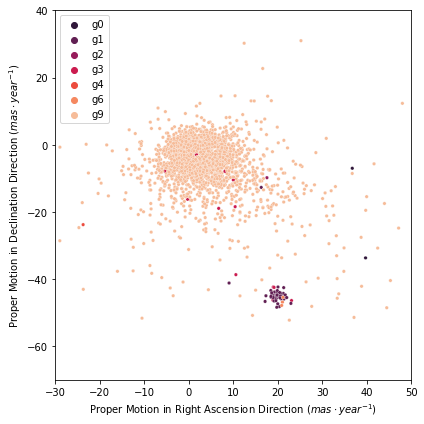

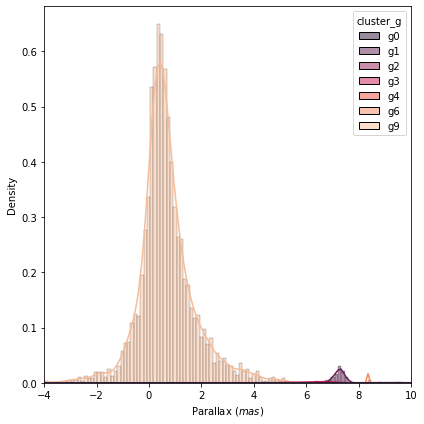

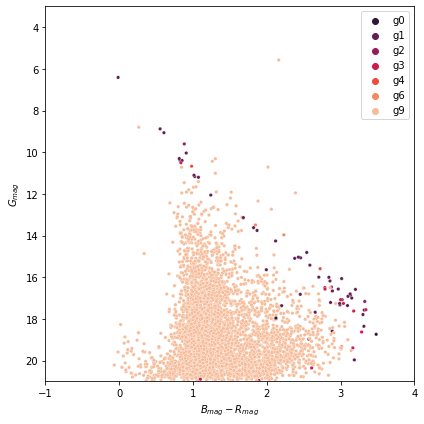

In [17]:
fig, ax, g = cplt.plot_cluster_proper_motion(stars_df, **pm_attr)
if save_data:
    cplt.save_figure(fig, name=f"dec_pm_{cluster.name}", **figures_attr)

fig, ax, g = cplt.plot_cluster_parallax_histogram(stars_df, **parallax_attr)
if save_data:
    cplt.save_figure(fig, name=f"dec_parallax_{cluster.name}", **figures_attr)

fig, ax, g = cplt.plot_cluster_hr_diagram_curve(stars_df, **hr_attr)
if save_data:
    cplt.save_figure(fig, name=f"dec_hr_diagram_{cluster.name}", **figures_attr)

In [18]:
cluster_centers(stars_df, key='cluster_g', columns=['pmra', 'pmdec', 'parallax'])

,pmra,pmdec,parallax
cluster_g,,,
g0,25.612429,-32.789665,9.039655
g1,19.553972,-43.757086,7.339251
g2,35.096033,-62.505033,13.552624
g3,14.250394,-24.146560,6.075945
g4,24.497588,-54.870313,10.512162
g5,-0.367071,-4.610185,0.000008
g6,24.941056,-43.795764,8.091811
g7,235.334621,-207.331305,28.186702
g8,114.760055,-120.453904,17.132634


In [19]:
dec_stats = cluster_stats(stars_df, key='cluster_g', columns=['pmra', 'pmdec', 'parallax'])
dec_stats.xs('std', axis=1, level=1, drop_level=False)

,pmra,pmdec,parallax
,std,std,std
cluster_g,,,
g0,25.359959,40.432809,0.345987
g1,9.013420,10.062596,0.185542
g2,62.929637,77.228632,1.387616
g3,25.004479,24.627880,0.537701
g4,61.938286,54.448194,0.464893
g5,NaN,NaN,NaN
g6,39.760082,25.841039,0.201152
g7,224.422143,385.151077,5.816404


In [20]:
stars_df['cluster_g'].value_counts()

g9    51184
g1      724
g3      289
g6       72
g0       42
g2       31
g4       24
g7        8
g8        7
g5        1
Name: cluster_g, dtype: int64

In [21]:
filtered_df = None
q = 0.1
for g in [f"g{x}" for x in range(n_clusters)]:
    df = stars_df[stars_df['cluster_g'] == g]
    mask = filter_outliers(df['parallax'], q)
    if filtered_df is None:
        filtered_df = df[mask]
    else:
        filtered_df = pd.concat([filtered_df, df[mask]])

In [22]:
if save_data:
    filtered_df.to_csv(f"{save_dir}/dec_characterization_filtered_{safe_path(cluster.name)}.csv")

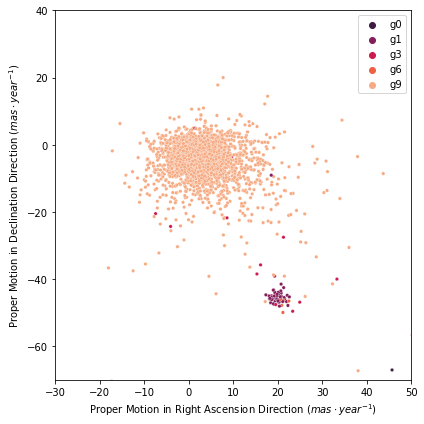

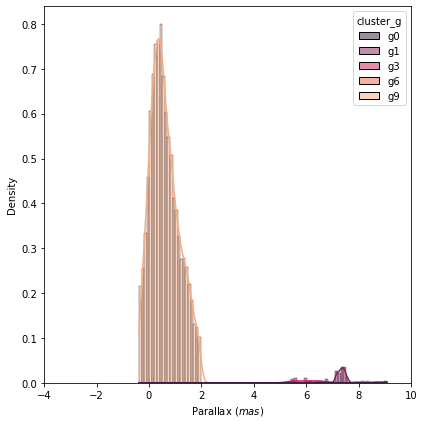

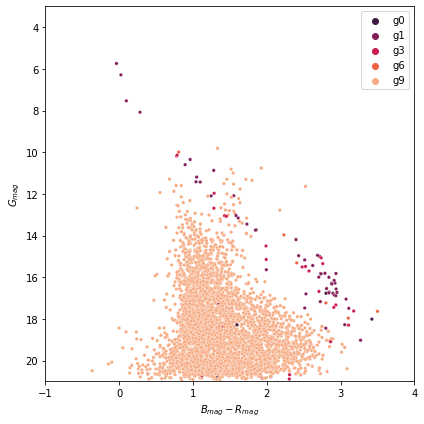

In [23]:
fig, ax, g = cplt.plot_cluster_proper_motion(filtered_df, **pm_attr)
if save_data:
    cplt.save_figure(fig, name=f"dec_pm_filtered_{cluster.name}", **figures_attr)

fig, ax, g = cplt.plot_cluster_parallax_histogram(filtered_df, **parallax_attr)
if save_data:
    cplt.save_figure(fig, name=f"dec_parallax_filtered_{cluster.name}", **figures_attr)

fig, ax, g = cplt.plot_cluster_hr_diagram_curve(filtered_df, **hr_attr)
if save_data:
    cplt.save_figure(fig, name=f"dec_hr_diagram_filtered_{cluster.name}", **figures_attr)

In [24]:
cluster_centers(filtered_df, key='cluster_g', columns=['pmra', 'pmdec', 'parallax'])

,pmra,pmdec,parallax
cluster_g,,,
g0,27.515378,-28.745232,9.027043
g1,19.647554,-44.502007,7.337616
g2,26.817595,-53.824282,13.553449
g3,13.420960,-24.431653,6.072606
g4,13.417271,-44.047557,10.518585
g6,28.302300,-44.476841,8.076048
g7,298.079241,-247.700192,26.694695
g8,147.935016,-121.068119,17.113673
g9,2.467401,-3.635085,0.613800


In [25]:
filtered_stats = cluster_stats(filtered_df, key='cluster_g', columns=['pmra', 'pmdec', 'parallax'])
filtered_stats.xs('std', axis=1, level=1, drop_level=False)

,pmra,pmdec,parallax
,std,std,std
cluster_g,,,
g0,25.837802,26.622086,0.274963
g1,7.980417,6.896928,0.123404
g2,57.737342,47.854229,1.138210
g3,25.399275,25.480527,0.465297
g4,54.884838,52.297933,0.305115
g6,36.669677,25.298684,0.161097
g7,216.406800,446.142278,2.598534
g8,146.773541,53.349940,0.604561


In [26]:
filtered_df['cluster_g'].value_counts()

g9    40946
g1      578
g3      231
g6       56
g0       32
g2       23
g4       18
g7        6
g8        5
Name: cluster_g, dtype: int64